Swiss Chess Tournament System

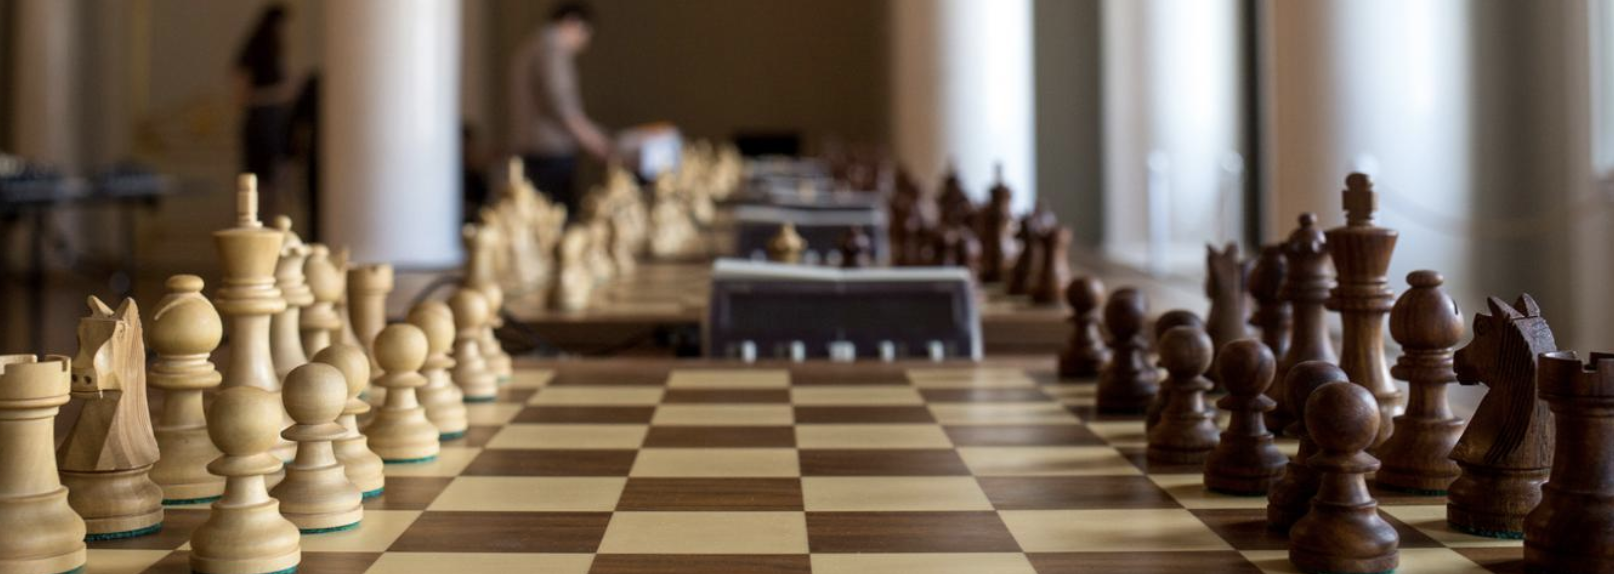

 A Swiss-system tournament is a non-eliminating tournament format which features a set number of rounds of competition, but considerably fewer than in a round-robin tournament. In a Swiss tournament, each competitor does not play every other. Competitors meet one-to-one in each round and are paired using a set of rules designed to ensure that each competitor plays opponents with a similar running score, but not the same opponent more than once. The winner is the competitor with the highest aggregate point total earned in all rounds. All competitors play in each round unless there is an odd number of players. We focus on chess and design a program to calculate pairings for players for a given round.
 
 
 - Input: Results and pairings of all previous rounds. See input chess file.
 - Output: Pairing for the next round (which player plays whom and what color do they get) satis- fying as many of the requirements of the Swiss System detailed below.
 
 
 - Some rules are:
     1. Two players shall not play against each other more than once.
     2. In general, players are paired to others with the same score.
     3. For each player the difference between the number of black and the number of white games shall not be greater than 2 or less than –2. Each system may have exceptions to this rule in the last round of a tournament.
     4. No player shall receive the same color three times in a row.
     5. In general, a player is given the color with which they played fewer games.
     6. If colors are already balanced, then, in general, the player is given the color that alternates from the last one with which they played.
     
     
 - Principal Objectives:
     1. Maximize the number of pairs.
     2. Maximize the number of paired players who were unpaired in the previous round.
     3. Minimize the number of players who have a color difference of 2 or -2.
     
We will try to comply as much as we can with these set of rules. We indentify constraints, major objectives, soft constraints so that we can get the best solution possible. Using data from the 7 first chess rounds, we want do determine the pairings for the 8th round.

IMPORT STATEMENTS:

In [1]:
import numpy as np
import pandas as pd
import openpyxl
import re
import numpy as np
from gurobipy import *

SETS: 

In [4]:
A = np.array(range(1, 95))
B = np.array(range(1, 95))

pairs_of_players_0 = [] #Each possible pair of players

for a in A:
    for b in A:
        if (b, a) not in pairs_of_players_0 and a!= b:
            pairs_of_players_0.append((a, b))

pairs_of_players = np.array(pairs_of_players_0)

J = np.array(range(1, 48)) # Each slot available
I = np.array(range(1, 95)) #Each participant
Q = np.array(range(1, 500000)) #Big list of numbers to create large scale decision variables

colors = ["W", "B", "N"]

Data Manipulation:
    To model our integer program, we have to determine our variables that will help us model our constraints and objectives. In this case we are going to divide our variables in two: decision variables, and coefficient variables. Decision Variables are the ones that will be determined by optimizing our integer program. In our program, all of our decision variables are integer and most of them are binary. Data variables are predetermined variables, in this case, data from previous swiss chess rounds. The combination of our two types of variables will allow us to optimize our integer program.
    

DATA VARIABLES:
    
1. W_i, B_i:
    White and Black rounds played per player
    input : excel columns with participants that played white or black
    ouptut: 2 dictionaries, one for white rounds and one for black             rounds, each has as key the ID of the player (1-94) and the value         corresponds to the total number of rounds played with black or           white.
      E.g. For "Shtembuliak Evgeny" the ID is 1:
          white_rounds[1] = 4  #Shtembuliak Evgeny played 4 white rounds
          black_rounds[1] = 3  #Shtembuliak Evegeny played 3 black rounds


In [4]:
x1 = openpyxl.load_workbook("Rounds.xlsx")

chess_rounds = {"Round 1": 54, "Round 2": 54, "Round 3": 53, "Round 4": 53, "Round 5": 53, "Round 6": 53, "Round 7":53}

white_rounds = {} #key = Participant ID, output = # of white games played
black_rounds = {} #key = Participant ID, output = # of black games playe

for rounda in chess_rounds:
    lista = [x1[rounda].cell(row = a, column = 2).value for a in range (7, chess_rounds[rounda])]
    
    for name in lista:
        if name in white_rounds:
            white_rounds[name] += 1
        else:
            white_rounds[name] = 1
                       
for rounda in chess_rounds:
    lista = [x1[rounda].cell(row = a, column = 18).value for a in range (7, chess_rounds[rounda])]
    
    for name in lista:
        if name in black_rounds:
            black_rounds[name] += 1
        else:
            black_rounds[name] = 1

 2. unpaired_player[i]: Unpaired Players from the last round

In [5]:
#Unpaired players from the last round:
# unpaired_player[i] = 0 if the player was paired, 1 if the player was unpaired

unpaired_player = {i:0 for i in I}
#We know from round 7 that player 11 and player 21 were unpaired, so:
unpaired_player[11] = 1
unpaired_player[21] = 1

3. P_mn: Participant m paired with participant n in any previous round:

In [6]:
previous_pairs = []
for rounda in chess_rounds:
    left_column = [x1[rounda].cell(row = a, column = 2).value for a in range (7, chess_rounds[rounda])]
    right_column = [x1[rounda].cell(row = a, column = 18).value for a in range (7, chess_rounds[rounda])]
    previous_pairs += list(zip(left_column, right_column))

# P[(m,n)] is a binary variable to denote if player m played with player n previously
p_mn = {}

for (m, n) in pairs_of_players:
    if (m, n) in previous_pairs:
        p_mn[(m, n)] = 1
    elif (n, m) in previous_pairs:
        p_mn[(m, n)] = 1
    else:
        p_mn[(m, n)] = 0

3. S_i: Running Score of player i

In [7]:


x1 = openpyxl.load_workbook("Rounds.xlsx")
sheet1 = x1["Round 7"]

lista = [str(sheet1.cell(row = a, column = 10).value) for a in range(7, 55)]

results1column = []

for a in lista:
    if a[0] != "½":
        results1column.append(int(a[0]))
    else:
        results1column.append(0.5)

results2column = []

for a in lista:
    if a[-1] != "½":
        results2column.append(int(a[-1]))
    else:
        results2column.append(0.5)

#print(results1column) # results of round 7 for left hand column of players in excel
#print(results2column) # results of round 7 for right hand column of players


lista2 = [sheet1.cell(row = a, column = 9).value for a in range(7, 55)]

points1 = []

for a in lista2:
    if type(a) is int:
        points1.append(a)
    elif a[0] != "½":
        points1.append(int(a[0])+ 0.5)
    else:
        points1.append(0.5)

#print(points1)

lista3 = [sheet1.cell(row = a, column = 11).value for a in range(7, 55)]

points2 = []

for a in lista3:
    if type(a) is int:
        points2.append(a)
    elif a[0] != "½":
        points2.append(int(a[0])+ 0.5)
    else:
        points2.append(0.5)

totalpoints1 = [a + b for (a, b) in zip(results1column, points1)]
totalpoints2 = [a + b for (a, b) in zip(results2column, points2)]


left_players = [sheet1.cell(row = a, column = 2).value for a in range(7, 55)]
right_players = [sheet1.cell(row = a, column = 18).value for a in range(7, 55)]

s_i = {a:b for (a,b) in zip(left_players, totalpoints1)}

for (a, b) in zip(right_players, totalpoints2):
    s_i[a] = b

4. R_ik: participant i received color k two times in a row previously

In [8]:
r_ik = {(i, k):0 for i in I for k in colors}

white_rounds_2 = {}
black_rounds_2 = {}

for rounda in ["Round 6", "Round 7"]:

    lista = [x1[rounda].cell(row = a, column = 2).value for a in range (7, chess_rounds[rounda])]
    
    for name in lista:
        if name in white_rounds_2:
            white_rounds_2[name] += 1
        else:
            white_rounds_2[name] = 1
            
for rounda in ["Round 6", "Round 7"]:

    lista = [x1[rounda].cell(row = a, column = 18).value for a in range (7, chess_rounds[rounda])]
    
    for name in lista:
        if name in black_rounds_2:
            black_rounds_2[name] += 1
        else:
            black_rounds_2[name] = 1

#print([(a, white_rounds_2[a]) for a in white_rounds_2 if white_rounds_2[a] == 2])
#print([(a, black_rounds_2[a]) for a in black_rounds_2 if black_rounds_2[a] == 2])

for player in white_rounds_2:
    if white_rounds_2[player] == 2:
        r_ik[(player, "W")] = 1
        
for player in black_rounds_2:
    if black_rounds_2[player] == 2:
        r_ik[(player, "B")] = 1

#print([a for a in r_ik if r_ik[a] == 0])

5. Color which player i received fewer games

In [9]:
fewer_games = {}

for i in I:
    result = white_rounds[i] - black_rounds[i]
    
    if result > 0:
        fewer_games[i] = "B"
    elif result < 0:
        fewer_games[i] = "W"
    elif result == 0:
        fewer_games[i] = 0

6. last_color[i]

In [10]:
lista1 = [x1["Round 7"].cell(row = a, column = 2).value for a in range (7, 53)]
lista2 = [x1["Round 7"].cell(row = a, column = 18).value for a in range (7, 53)]

last_color = {}

for i in lista1:
    last_color[i] = "W"
for i in lista2:
    last_color[i] = "B"
    
last_color[21] = "B"
last_color[11] = "B"

In [11]:
J_name = [f"Y[{str(a)}]" for a in J] #name for Y[j] variable

player_in_slot = [(i, j) for i in I for j in J] # X[i, j]
player_in_slot_name = [f"X[{i},{j}]" for i in I for j in J] #name for X[i, j]

player_assigned_color = [(i, k) for i in I for k in colors]
player_assigned_color_name = [f"C[{i},{k}]" for (i, k) in player_assigned_color]

var_z = [q for q in Q]
var_e = [q for q in range(1, 500000)]
var_t = [q for q in range(1, 500000)]
var_u = [q for q in range(1, 94)]
var_m2 = [i for i in I]

#z_variable = [p for p in range()]

PROGRAM

In [12]:
try:
    m = Model("mip1")
    
    #Decision Variables:
    
    x = m.addVars(player_in_slot, vtype = GRB.BINARY, name = player_in_slot_name) #X[i, j]
    y = m.addVars(J, vtype = GRB.BINARY, name = J_name)
    c = m.addVars(player_assigned_color, vtype = GRB.BINARY, name = player_assigned_color_name)
    
    z = m.addVars(var_m2, vtype = GRB.BINARY)
    k = m.addVars(I, vtype = GRB.BINARY)
    l = m.addVars(I, vtype = GRB.BINARY)
    
    c7 = m.addVars([a for a in range(1, 24915)], vtype = GRB.BINARY)
    c8 = m.addVars([a for a in range(1, 209810)], vtype = GRB.BINARY)
    c9 = m.addVars([a for a in range(1, 420000)], vtype = GRB.BINARY)
    c10 = m.addVars(var_t, vtype = GRB.BINARY)
    c11 = m.addVars(var_u, vtype = GRB.BINARY)
    c12 = m.addVars([a for a in range(1, 95)],vtype = GRB.BINARY)
    c13 = m.addVars([a for a in range(1, 95)],vtype = GRB.BINARY)
    c14 = m.addVars([a for a in range(1, 95)],vtype = GRB.BINARY)
    c15 = m.addVars([a for a in range(1, 200)], vtype = GRB.BINARY)
    c16 = m.addVars([a for a in range(1, 200)], vtype = GRB.BINARY)

    
    #Constraints:
    
    # (1) Two players shall not play against each other more than once
    for (a, b) in p_mn:
        if p_mn[(a, b)] == 1:
            for j in J:
                m.addConstr(x[a, j] + x[b, j] <= 1)
    
    # (2) For each slot there can only be 2 or 0 players
    for j in J:
        m.addConstr(sum([x[i, j] for i in I]) - 2*y[j] == 0)
    
    # (3) Each participant can only be at most in one pair
    for i in I:
        m.addConstr(sum(x[i, j] for j in J) <= 1)
        
    # (4) A player can only be assigned “White”, “Black”, or “Not assigned color”.
    for i in I:
        m.addConstr(sum(c[i, k] for k in colors) == 1)
                
    # (5) No player shall receive the same color three times in a row
    for (a,b) in r_ik:
        if r_ik[a,b] == 1:
            m.addConstr(c[a,b] == 0)
    
    # (6) The difference between the number of black and the
    #number of white games shall not be greater than 2 or less than -2.
    for i in I:
        m.addConstr(white_rounds[i] - black_rounds[i] + c[i, "W"] - c[i, "B"] <= 2) 
        m.addConstr(white_rounds[i] - black_rounds[i] + c[i, "W"] - c[i, "B"] >= -2) 
    
    # (7) In general, players with the same running score are paired
    i = 1
    for (a, b) in pairs_of_players:
        if s_i[a] == s_i[b]:
            for j in J:
                m.addConstr(x[a, j] - c7[i] >= 0)
                m.addConstr(x[b, j] - c7[i] >= 0)
                i += 1
                
    #(8) In general, players with a difference running score of 0.5 are paired
    #i = 1
    #for (a, b) in pairs_of_players:
     #   if s_i[a]+ 0.5 == s_i[b] or s_i[b] + 0.5 == s_i[a]:
      #      for j in J:
       #         m.addConstr(x[a, j] - c8[i] >= 0)
        #        m.addConstr(x[b, j] - c8[i] >= 0)
        #        i += 1
        #else:
         #   m.addConstr(c8[i] == 0)
          #  i += 1
    
    # (9) For each pair of players that will play against each other, 
    #one plays with white and the other with black.
    d = 1
    for j in J:
        for (a,b) in pairs_of_players:
            m.addConstr(1-x[a,j]-x[b,j]+c9[d]+c9[d+1] >=0)
            m.addConstr(c[a, "B"]+c[b, "W"] + 8 - 10*c9[d] >= 0)
            m.addConstr(c[a, "W"]+c[b, "B"] + 8 - 10*c9[d+1] >= 0)
            d += 2
            
    # (10) In general, a player is given the color with which they played fewer games
    
    for i in I:
        if fewer_games[i] == "W":
            m.addConstr(c[i, "W"] >= c10[i])
        elif fewer_games[i] == "B":
            m.addConstr(c[i, "B"] >= c10[i])
            
    # (11) If colors are already balanced, then, in general, the player is given
    # the color that alternates from the last one with which they played
    for i in I:
        if white_rounds[i] == black_rounds[i]:
            if last_color[i] == "W":
                m.addConstr(c[i, "B"] >= c11[i])
            elif last_color[i] == "B":
                m.addConstr(c[i, "W"] >= c11[i])
            
    # (12) Maximize the number of players who where unpaired in the previous round
    
    for i in I:
        if unpaired_player[i] == 1:
            m.addConstr(c12[i] >= z[i])
            m.addConstr(sum(x[i, j] for j in J) + 9 - 10*c12[i] >= 0)
        else:
            m.addConstr(c12[i] == 0)
            
    #(13) A strong colour preference for black occurs when a player's colour difference is +1
    for i in I:
        if white_rounds[i] - black_rounds[i] == 1:
            m.addConstr(c[i, "B"] >= c13[i])
        else:
            m.addConstr(c13[i] == 0) 
    
    #(14) A strong colour preference for white occurs when a player's colour difference is -1
    i = 1
    for i in I:
        if white_rounds[i] - black_rounds[i] == -1:
            m.addConstr(c[i, "W"] >= c14[i])
            i += 1
    
    # (15) Minimize the number of players that have a color difference of 2
    d = 1
    for i in I:
        m.addConstr(white_rounds[i] - black_rounds[i] + c[i, "W"] - c[i, "B"] - 2 >= - 10 +10*c15[d])
        m.addConstr(white_rounds[i] - black_rounds[i] + c[i, "W"] - c[i, "B"] - 2 <= 10 - 10*c15[d+1])
        m.addConstr(c15[d] >= k[i])
        m.addConstr(c15[d+1] >= k[i])
        d += 2
    
    # (16)Minimize the number of players that have a color difference of -2
    d = 1
    for i in I:
        m.addConstr(white_rounds[i] - black_rounds[i] + c[i, "W"] - c[i, "B"] + 2 >= - 10 +10*c16[d])
        m.addConstr(white_rounds[i] - black_rounds[i] + c[i, "W"] - c[i, "B"] + 2 <= 10 - 10*c16[d+1])
        m.addConstr(c16[d] >= l[i])
        m.addConstr(c16[d+1] >= l[i])
        d += 2
                 
    #Objective:
    m.setObjective(100*y.sum() + 50*z.sum() - 20*k.sum() - 20*l.sum() + 600*c7.sum() + c10.sum() + c11.sum() + c13.sum() + c14.sum(), GRB.MAXIMIZE)
    m.optimize()  
                      
    print('Obj: %g' % m.objVal)
  
    #for v in m.getVars():
        #print('%s %g' % (v.varName, v.x))

except GurobiError as e:
    print('Error code ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Encountered an attribute error')

Using license file /Users/user/gurobi.lic
Error code 10009: License expired 2020-10-22


In [13]:
def player_plays_with():
    pairs = []
    for j in J:
        pair = []
        for i in I:
            if x[i, j].x == 1:
                pair.append(i)
        pair.append(j)
        pairs.append(pair)

    for pair in pairs:
        if len(pair) == 3:

            color_variables_1 = [c[pair[0],"W"], c[pair[0],"B"]]
            color_variables_2 = [c[pair[1],"W"], c[pair[1],"B"]]

            for color in color_variables_1:
                if color.x == 1:
                    color_1 = re.search(',(.*?)\]', color.varName).group(1)
                    color_1_text = f"Player {pair[0]} plays {color_1}" #+ color_1
            for color in color_variables_2:
                if color.x == 1:
                    color_2 = re.search(',(.*?)\]', color.varName).group(1)
                    color_2_text = f" and player {pair[1]} plays {color_2}."# + color_2

            print(f"Player {pair[0]} plays with player {pair[1]} in slot {pair[2]}. " + color_1_text + color_2_text)
        else:
            print(f"Slot {pair[0]} is empty.")
player_plays_with()

NameError: name 'x' is not defined

Result 2: Score difference in players

In [ ]:
def score_difference():
    total_score_difference = 0
    pairs = []
    for j in J:
        pair = []
        for i in I:
            if x[i, j].x == 1:
                pair.append(i)
        pair.append(j)
        pairs.append(pair)

    for pair in pairs:
        if len(pair) == 3:
            print(f"Player {pair[0]} and player {pair[1]} have a score difference of {s_i[pair[0]]-s_i[pair[1]]}.")
            total_score_difference += abs(s_i[pair[0]] - s_i[pair[1]])

    print(f"The total score difference is: {total_score_difference}.")

score_difference()

Result 3: Players who where unpaired in this round

Due to the high weight we gave to the variable "z" within the objective value, and that we only had 2 unpaired players in the previous round, it is highly unlikely we get a solution where player 11 or player 21 are unpaired.

In [ ]:
def unpaired_players():
    unpaired_players = []
    for i in I:
        count = 0
        for j in J:
            count += x[i, j].x
        if count == 0:
            unpaired_players.append(i)

    for player in unpaired_players:
        print(f"Player {player} is unpaired")

unpaired_players()